In [64]:
import pandas as pd
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import levene

# Load data

In [65]:
n_threads = 5

In [66]:
df_res = None
for i in range(n_threads):
    df = pd.read_csv(f'./out/stream_{i}.csv')
    df['delay'] = df['arrival_time'] - df['event_time']
    df['thread'] = i
    if df_res is not None:
        df_res = pd.concat([df_res, df])
    else:
        df_res = df

In [67]:
df_res.head()

,arrival_time,event_time,updateId,delay,thread
0,1.692440e+12,1692440160819,3180680103055,660.498291,0
1,1.692440e+12,1692440160830,3180680103311,660.498291,0
2,1.692440e+12,1692440160839,3180680103827,662.012207,0
3,1.692440e+12,1692440160847,3180680104173,660.010742,0
4,1.692440e+12,1692440160857,3180680104441,661.013184,0


# Distribution graph

C:\Users\Custos\PycharmProjects\alberBlancTest\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


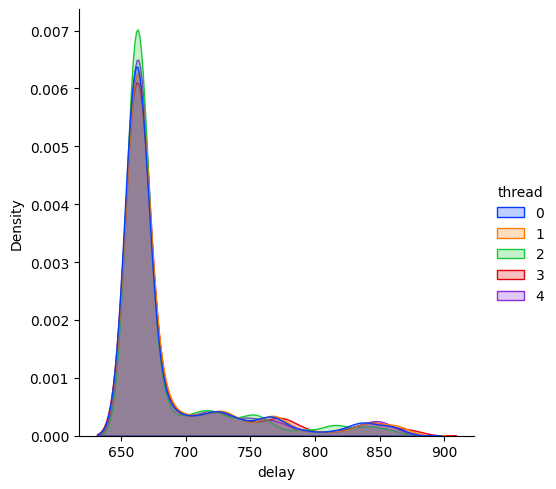

In [68]:
sns.displot(data=df_res, x='delay', hue='thread', kind='kde', fill=True, palette=sns.color_palette('bright')[:n_threads])

# Count fast connections

In [69]:
pivot_df = df_res.pivot(index='updateId', columns='thread', values='delay')
# We could use this code, but it gives advantage to first threads since if values are identical only first thread will be counted
# pivot_df['lowest_thread'] = pivot_df.apply(lambda row: row[1:].idxmin(), axis=1)

# Instead, let's count percentages for each thread by hand
def find_lowest_threads(row):
    lowest_value = row.min()
    lowest_threads = list(row.loc[row == lowest_value].index)
    return lowest_threads
    
pivot_df['lowest_threads'] = pivot_df.apply(find_lowest_threads, axis=1)
pivot_df.head()

thread,0,1,2,3,4,lowest_threads
updateId,,,,,,
3180680103055,660.498291,661.502441,660.498291,661.502441,661.502441,"[0, 2]"
3180680103311,660.498291,660.498291,660.498291,659.497559,660.498291,[3]
3180680103827,662.012207,662.012207,662.012207,662.012207,662.012207,"[0, 1, 2, 3, 4]"
3180680104173,660.010742,662.012939,661.011963,661.011963,662.012939,[0]
3180680104441,661.013184,661.013184,661.013184,660.011230,661.013184,[3]


In [70]:
counts = [0 for i in range(n_threads)]
for value_list in pivot_df['lowest_threads']:
    for value in value_list:
        counts[value] += 1

In [71]:
counts

[2789, 1096, 2094, 1746, 1089]

# Count statistics

In [72]:
# Distribution of data is unknown (can't use t-test), we have several groups, so we will use Kruskal-Wallis test
# with H_0 that says that all medians are equal
data = []
for i in range(n_threads):
    thread_data = df_res[df_res['thread'] == i]
    data.append(thread_data['delay'])
stat, p = kruskal(*data)
print(p)
if p < 0.05:
    print('Medians are not equal')
else:
    print('Medians are equal')

7.526204539247201e-30
Medians are not equal


In [73]:
# Levene is non parametrical test for multiple samples
data = []
for i in range(n_threads):
    thread_data = df_res[df_res['thread'] == i]
    data.append(thread_data['delay'])
stat, p = levene(*data)
print(p)
if p < 0.05:
    print('Deviations are not equal')
else:
    print('Deviations are equal')

0.002155175630591414
Deviations are not equal


# Conclusion

Overall we can clearly see that distributions for different threads are not equal. There might be several reasons for that:
1. In this analysis we use multithreading module. Because of the GIL only one thread is executed at a time, which causes delays. To compare how using multiprocessing will impact our results, check out Analysis_mp.ipynb
2. There might be hardware delays, for example different traffic routes at different moments of time, or unstable Wi-Fi connection on my side.
3. Other software on the client side can also impact performance. For example, sudden Windows update, some scheduled programm that took computational resources and so on.